In [1]:
import numpy as np
import pandas as pd
import math
import json
import sys
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from itertools import combinations


### data manipulation

In [2]:
def readFiles(filename):
    df = pd.read_csv(filename, header=None)
    
    # restrictions are in first row
    restr = pd.to_numeric(df.iloc[0])
    
    # drop metadata columns
    df = df.drop([0], axis=0)
    
    return df, restr

In [3]:
def restrictdf(df, restr, setIndex=False, getDropped=False):
    # remove restricted cols and convert to numeric
    dropped=pd.DataFrame()
    for i, v in enumerate(df.columns):
        if restr[i] == 0 and setIndex:
            df = df.set_index(df.columns[i])
        elif restr[i] < 1:
            dropped[v] = df[v]
            df = df.drop(columns=[v])
        else:
            df[v] = pd.to_numeric(df[v], errors='coerce')
            
    # drop unknown values
    df = df.dropna()
    df = df[(df != '?').all(axis=1)]
    if getDropped:
        return df, dropped
    return df

In [4]:
# normalizes all columns
def normalizedf(indf):
    df=indf.copy()
    for c in df.columns:
        colMax = df[c].max()
        colMin = df[c].min()
        
        # probably no need to normalize if the values are very small. Might have to adjust the value
#         if colMax < 1:
#             continue
        df[c] = df[c].apply(lambda x: (x - colMin)/(colMax-colMin))
    return df

### helper functions

In [5]:
def euclideanDist(point, pointArray):
    return np.sqrt(np.sum((pointArray - point) ** 2, axis=1))

In [6]:
def initCentroids_random(numdf, k):
    if k>=len(numdf):
        print('k cannot be bigger than the length of data')
        exit(1)
    sample=np.array(numdf.sample(k))
    while len(np.unique(sample)) < k:
        sample=np.array(numdf.sample(k))
    return sample


In [7]:
def calcCentroid(dfarray):
    return np.divide(np.sum(dfarray, axis=0),len(dfarray))

In [8]:
def initCentroids_max(indf, k, distFunc):
    if indf.columns[-1] == 'cluster':
        numdf = indf.drop('cluster')
    else:
        numdf=indf.copy()
    
    dfarray = np.array(numdf)
    c = calcCentroid(dfarray)
    centroids=[]
    
    centroids.append(np.array(numdf.iloc[np.argmax(distFunc(c, dfarray))]))
    duplicates=[]
    
    numiters=0
    while len(centroids) < k and numiters < len(df):
        numiters+=1
        sumdist = None
        for c in centroids + duplicates:
            if sumdist is None:
                sumdist = distFunc(c, dfarray)
            else:
                sumdist = np.add(sumdist, distFunc(c, dfarray))
        newCentroid = np.array(numdf.iloc[np.argmax(sumdist)])
        if newCentroid.tolist() in np.array(centroids).tolist():
            duplicates.append(newCentroid)
        else:
            centroids.append(newCentroid)
    return centroids

In [9]:
# pass a ***vectorized*** distance function: dist(point, pointArray)
# dataframe must be numeric other than last column
def assignCentroids(numdf, centroids, distfunc, getNumAssign = False):
    if df.columns[-1] != 'cluster':
        df['cluster'] = -1
    numAssign=0
    
    for i, row in df.iloc[:,:-1].iterrows():
        prev = df.at[i,'cluster']
        new = np.argmin(distfunc(row.values, centroids))
        if prev != new:
            numAssign += 1
        df.at[i,'cluster'] = new
    if getNumAssign:
        return df, numAssign
    return df


In [10]:
def reCalcCentroids(numdf, centroids):
    # centroid index is tag
    for i in range(len(centroids)):
        cluster = numdf[numdf['cluster'] == i]
        centroids[i] = np.mean(np.array(cluster.iloc[:,:-1]), axis=0)
    return centroids

In [11]:
def calcSSE(dfarray, c, distFunc):
    return np.sum(np.square(distFunc(c, dfarray)))

In [12]:
# takes labeled numeric df
def calcTotSSE(numdf, centroids, distFunc):
    totSSE=None
    for i, c in enumerate(centroids):
        cSSE = calcSSE(np.array(numdf[numdf['cluster'] == i].iloc[:,:-1]), c, distFunc)
        if totSSE is None:
            totSSE = cSSE
        else:
            totSSE += cSSE
    return totSSE

### kmeans 

In [13]:
def kmeans_sse(df, centroids, distFunc, minSSE):
    df = assignCentroids(df, centroids, distFunc)
    prevSSE = calcTotSSE(df, centroids, distFunc)
    
    centroids = reCalcCentroids(df, centroids)
    df = assignCentroids(df, centroids, distFunc)
    currSSE = calcTotSSE(df, centroids, distFunc)
    print(f"current sse: {currSSE}")
    
    counter = 0
    while counter < 10 and prevSSE - currSSE > minSSE:
        centroids = reCalcCentroids(df, centroids)
        df = assignCentroids(df, centroids, distFunc)
        prevSSE = currSSE
        currSSE = calcTotSSE(df, centroids, distFunc)
        print(f"current sse: {currSSE}")
        
        counter += 1
    return df, centroids

In [14]:
def kmeans_reassign(df, centroids, distFunc, minReassign):
    df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
    print(f"{numAssign} points reassigned")
    
    centroids = reCalcCentroids(df, centroids)
    df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
    print(f"{numAssign} points reassigned")
    
    counter = 0
    while counter < 100 and numAssign > minReassign:
        centroids = reCalcCentroids(df, centroids)
        df, numAssign = assignCentroids(df, centroids, distFunc, getNumAssign=True)
        print(f"{numAssign} points reassigned")
        counter += 1
    return df, centroids

### analytical functions

In [15]:
# takes numeric df with cluster labe
def analyzeClusters(df, centroids, distFunc, extraCols = None):
    clusters=[]
    for i, c in enumerate(centroids):
        info = {}
        info["clusterID"] = i
        pnts = df[df['cluster'] == i]
        if len(pnts) == 0:
            continue
        
        info["SSE"] = calcSSE(np.array(pnts.iloc[:,:-1]), c, distFunc)
        info["centroid"] = c
        
        dists = distFunc(c, np.array(pnts.iloc[:,:-1]))
        info["maxDistToCentroid"] = max(dists)
        info["minDistToCentroid"] = min(dists)
        info["avgDistToCentroid"] = np.sum(dists)/len(pnts)
        info["numPoints"] = len(pnts)
        if extraCols is not None:
            pnts = pnts.join(extraCols)
        info["dataPoints"] = pnts
        clusters.append(info)
    return clusters

In [16]:
def printClusterInfo(clusters, noData=False):
    for clusterInfo in clusters:
        for key in clusterInfo:
            if key == "dataPoints":
                if not noData:
                    print(f"{key}: \n{clusterInfo[key].to_markdown()}")
            else:
                print(f"{key}: {clusterInfo[key]}")
        print('\n')

### running

In [17]:
# k=4

# sys.argv = f"dbscan.py ./data/4clusters.csv {k}".split(" ")
# if __name__ == "__main__":
#     if len(sys.argv) == 3:
#         _, datafile, k = sys.argv
#     else:
#         print("Usage: python3 dbscan.py <datafile.csv> <epsilon> <numPoints>")
#         exit(1)
        
#     k = int(k)
#     df_full, restr = readFiles(datafile)
#     df = restrictdf(df_full, restr, getDropped=True)
#     df = df
#     centroids = initCentroids(df,k)
#     df, centroids = kmeans_lite(df, centroids, euclideanDist)
#     df.plot.scatter(x=0,y=1,c='cluster',colormap='viridis')    
# #     print(dropped)
# #     df = df.join(dropped)
# #     print(df.to_markdown())
#     printClusterInfo(analyzeClusters(df, centroids, euclideanDist), extraCols = dropped)

### Iris

In [18]:
def calcPurity(col):
    vals = col.value_counts()
    return max(vals)/len(col)

In [22]:
df_full, restr = readFiles('./data/iris.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

# centroids = initCentroids_max(df, 3, euclideanDist)
centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 0.3)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)
print()
sumpurity=0
for c in clusters:
    pur = calcPurity(pnts.iloc[:,-1])
    sumpurity += pur
    pnts = c["dataPoints"]
    print(f"purity of cluster {c['clusterID']}: {pur}")
print(f"mean purity: {sumpurity/len(clusters)}")
print()
printClusterInfo(clusters, noData=True)
# for i in range(4):
#     for j in range(4):
#         if i != j:
#             fig = plt.figure(figsize = (10, 7))
#             ax = plt.axes(projection ="3d")
#             cb = ax.scatter3D(df[0], df[1], df[2], c=df['cluster'], cmap='tab10')
#             plt.colorbar(cb)
#             plt.title(f"Plot of attributes 1-3 for AccidentsSet01")
            
#             df.plot.scatter(x=i,y=j,c='cluster',colormap='viridis')    

for combo in combinations(df.columns[:-1], 3):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    cb = ax.scatter3D(df[combo[0]], df[combo[1]], df[combo[2]], c=df['cluster'], cmap='viridis')
    plt.colorbar(cb)
    plt.title(f"Plot of attributes {combo[0]} {combo[1]} {combo[2]} for Iris.csv")

current sse: 144.57711286924535
current sse: 143.59505622837372
current sse: 143.2842684779658
current sse: 143.02941605784326



NameError: name 'pnts' is not defined

### 4clusters

current sse: 1663.7096875
current sse: 1584.9876543209875
current sse: 1554.7743055555554

clusterID: 0
SSE: 1164.111111111111
centroid: [33.16666667 17.27777778]
maxDistToCentroid: 12.124101086698913
minDistToCentroid: 2.2838671990104937
avgDistToCentroid: 7.579450143514094
numPoints: 18


clusterID: 1
SSE: 233.21875000000003
centroid: [12.875 39.25 ]
maxDistToCentroid: 12.189262693042595
minDistToCentroid: 0.7603453162872774
avgDistToCentroid: 4.980787048467772
numPoints: 6


clusterID: 2
SSE: 86.44444444444443
centroid: [41.11111111 41.77777778]
maxDistToCentroid: 4.275973645531965
minDistToCentroid: 0.7856742013183874
avgDistToCentroid: 2.9117006199139848
numPoints: 9


clusterID: 3
SSE: 71.0
centroid: [10. 35.]
maxDistToCentroid: 5.0
minDistToCentroid: 1.4142135623730951
avgDistToCentroid: 3.2141158591734738
numPoints: 6




<AxesSubplot:xlabel='0', ylabel='1'>

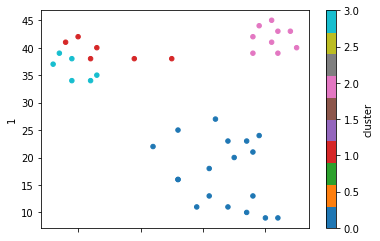

In [20]:
df_full, restr = readFiles('./data/4clusters.csv')
df = restrictdf(df_full, restr)

centroids = initCentroids_max(df, 4, euclideanDist)
# centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 50)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
printClusterInfo(clusters, noData=True)
df.plot.scatter(x=0,y=1,c='cluster', colormap='tab10')    

### many clusters

current sse: 3873.9952380952377
current sse: 3873.9952380952377

clusterID: 0
SSE: 706.6666666666667
centroid: [12.13333333  8.73333333]
maxDistToCentroid: 14.949544771961751
minDistToCentroid: 1.2736648783028541
avgDistToCentroid: 5.908993894764435
numPoints: 15
dataPoints: 
|    |   0 |   1 |   cluster |
|---:|----:|----:|----------:|
| 48 |  23 |  19 |         0 |
| 50 |  11 |  18 |         0 |
| 54 |   7 |  14 |         0 |
| 55 |  21 |  13 |         0 |
| 57 |  12 |  10 |         0 |
| 58 |  16 |   9 |         0 |
| 59 |   5 |   8 |         0 |
| 61 |   9 |   7 |         0 |
| 62 |  11 |   7 |         0 |
| 64 |  10 |   6 |         0 |
| 65 |  13 |   6 |         0 |
| 68 |   9 |   5 |         0 |
| 69 |  11 |   5 |         0 |
| 71 |  10 |   3 |         0 |
| 73 |  14 |   1 |         0 |


clusterID: 1
SSE: 1335.2
centroid: [38.3 33.5]
maxDistToCentroid: 11.67647206993619
minDistToCentroid: 0.5830951894845285
avgDistToCentroid: 7.733005699688557
numPoints: 20
dataPoints: 
|    |  

<AxesSubplot:xlabel='0', ylabel='1'>

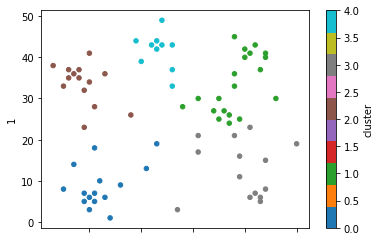

In [21]:
df_full, restr = readFiles('./data/many_clusters.csv')
df = restrictdf(df_full, restr)

centroids = initCentroids_max(df, 5, euclideanDist)
# centroids = initCentroids_random(df, 3)

# df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist)

print()
printClusterInfo(clusters)
df.plot.scatter(x=0,y=1,c='cluster', colormap='tab10')    

### mammal milk

25 points reassigned
5 points reassigned
4 points reassigned
2 points reassigned
3 points reassigned
2 points reassigned
0 points reassigned

clusterID: 0
SSE: 27.191200000000013
centroid: [45.65 10.15 38.45  0.45  0.69]
maxDistToCentroid: 3.6872211758992752
minDistToCentroid: 3.6872211758992677
avgDistToCentroid: 3.6872211758992712
numPoints: 2
dataPoints: 
|    | 0       |
|---:|:--------|
| 24 | Seal    |
| 25 | Dolphin |


clusterID: 1
SSE: 22.429333333333336
centroid: [82.          7.11666667  6.46666667  4.18333333  0.88666667]
maxDistToCentroid: 3.025504549290544
minDistToCentroid: 1.1240749283052491
avgDistToCentroid: 1.8433834193301044
numPoints: 6
dataPoints: 
|    | 0          |
|---:|:-----------|
|  8 | Buffalo    |
|  9 | Guinea Pig |
| 10 | Cat        |
| 11 | Fox        |
| 14 | Pig        |
| 16 | Sheep      |


clusterID: 2
SSE: 78.76730000000003
centroid: [66.55   8.95  19.7    3.075  1.07 ]
maxDistToCentroid: 7.5381844631184185
minDistToCentroid: 1.6910130100031786


<AxesSubplot:xlabel='3', ylabel='1'>

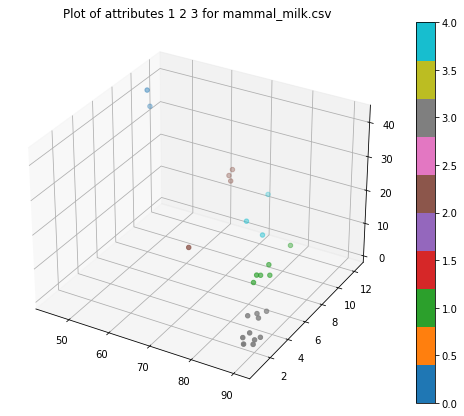

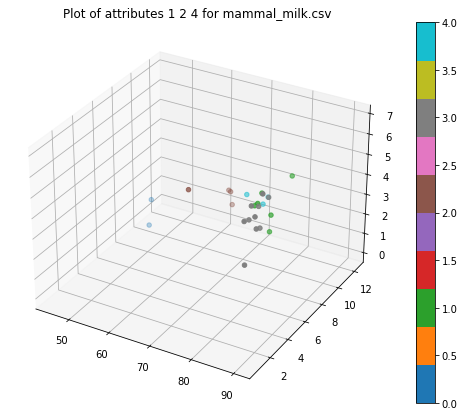

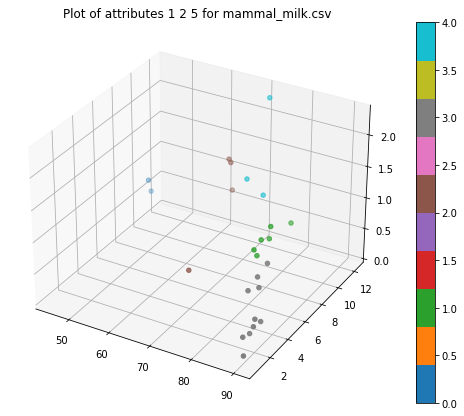

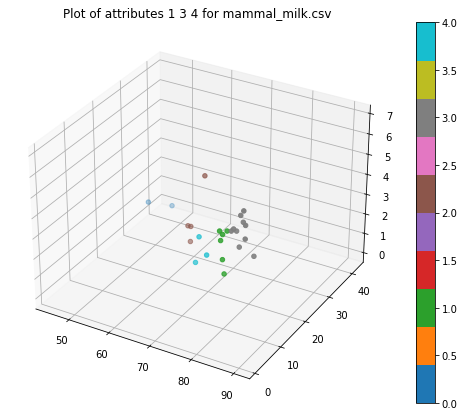

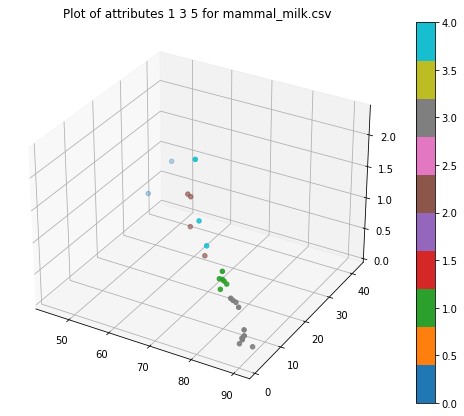

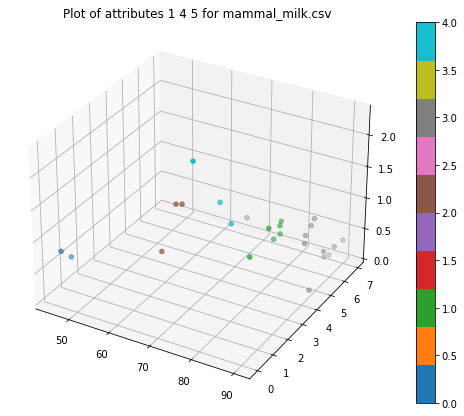

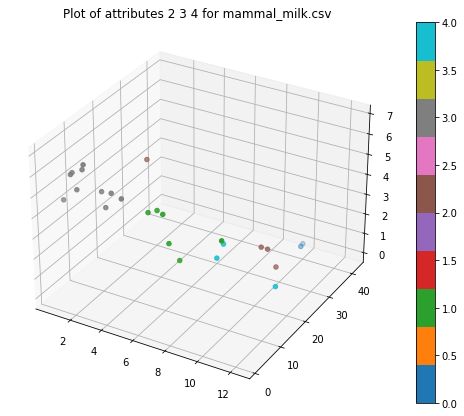

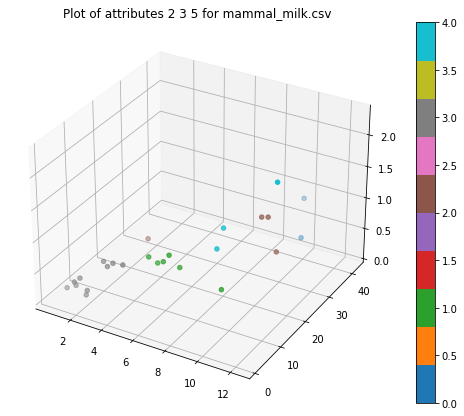

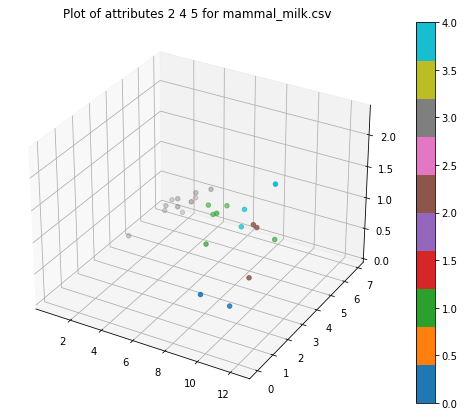

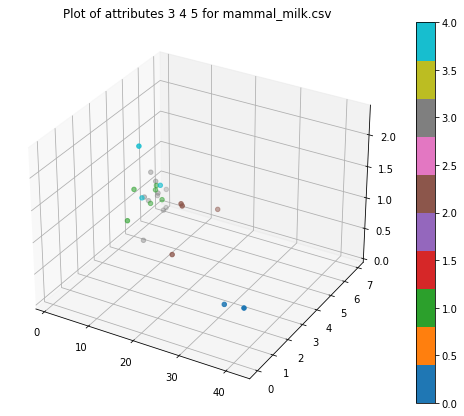

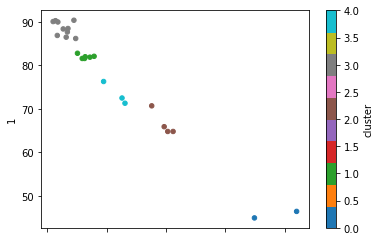

In [333]:
df_full, restr = readFiles('./data/mammal_milk.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

centroids = initCentroids_max(df, 5, euclideanDist)
# centroids = initCentroids_random(df, 5)

df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
# df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
for clusterInfo in clusters:
    for key in clusterInfo:
        if key == "dataPoints":
            print(f"{key}: \n{clusterInfo[key].iloc[:,-1].to_markdown()}")
        else:
            print(f"{key}: {clusterInfo[key]}")
    print('\n')

for combo in combinations(df.columns[:-1], 3):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    cb = ax.scatter3D(df[combo[0]], df[combo[1]], df[combo[2]], c=df['cluster'], cmap='tab10')
    plt.colorbar(cb)
    plt.title(f"Plot of attributes {combo[0]} {combo[1]} {combo[2]} for mammal_milk.csv")

df.plot.scatter(x=3,y=1,c='cluster', colormap='tab10') 

### accidents 1

19 points reassigned
1 points reassigned
0 points reassigned

clusterID: 0
SSE: 0.0
centroid: [ 2. 19.  2.]
maxDistToCentroid: 0.0
minDistToCentroid: 0.0
avgDistToCentroid: 0.0
numPoints: 1
dataPoints: 
|    |   cluster |
|---:|----------:|
| 11 |         0 |


clusterID: 1
SSE: 24.875
centroid: [2.    3.125 2.   ]
maxDistToCentroid: 2.7414640249326636
minDistToCentroid: 0.875
avgDistToCentroid: 1.6467460440475654
numPoints: 8
dataPoints: 
|    |   cluster |
|---:|----------:|
| 12 |         1 |
| 13 |         1 |
| 14 |         1 |
| 15 |         1 |
| 16 |         1 |
| 17 |         1 |
| 18 |         1 |
| 19 |         1 |


clusterID: 2
SSE: 64.1
centroid: [ 5.  10.3  1. ]
maxDistToCentroid: 4.699999999999999
minDistToCentroid: 0.3000000000000007
avgDistToCentroid: 2.16
numPoints: 10
dataPoints: 
|    |   cluster |
|---:|----------:|
|  1 |         2 |
|  2 |         2 |
|  3 |         2 |
|  4 |         2 |
|  5 |         2 |
|  6 |         2 |
|  7 |         2 |
|  8 |         2 

Text(0.5, 0.92, 'Plot of attributes 1-3 for AccidentsSet01')

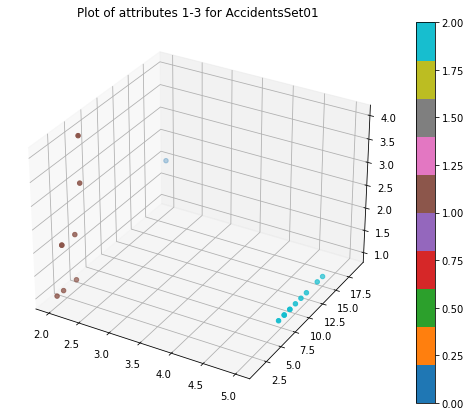

In [336]:
df_full, restr = readFiles('./data/AccidentsSet01.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

centroids = initCentroids_max(df, 3, euclideanDist)
# centroids = initCentroids_random(df, 5)

df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
# df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
for clusterInfo in clusters:
    for key in clusterInfo:
        if key == "dataPoints":
            print(f"{key}: \n{clusterInfo[key].iloc[:,-1].to_markdown()}")
        else:
            print(f"{key}: {clusterInfo[key]}")
    print('\n') 


fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
cb = ax.scatter3D(df[0], df[1], df[2], c=df['cluster'], cmap='tab10')
plt.colorbar(cb)
plt.title(f"Plot of attributes 1-3 for AccidentsSet01")


### accidents 3

62 points reassigned
9 points reassigned
3 points reassigned
2 points reassigned
1 points reassigned
0 points reassigned

clusterID: 0
SSE: 0.0
centroid: [10.  0.  4.  1.  1.]
maxDistToCentroid: 0.0
minDistToCentroid: 0.0
avgDistToCentroid: 0.0
numPoints: 1
dataPoints: 
|    |   cluster |
|---:|----------:|
|  7 |         0 |


clusterID: 1
SSE: 2.9999999999999996
centroid: [1.  0.  3.  2.5 2.5]
maxDistToCentroid: 1.224744871391589
minDistToCentroid: 1.224744871391589
avgDistToCentroid: 1.224744871391589
numPoints: 2
dataPoints: 
|    |   cluster |
|---:|----------:|
| 23 |         1 |
| 30 |         1 |


clusterID: 2
SSE: 101.54285714285716
centroid: [2.17142857 0.25714286 2.51428571 1.02857143 0.62857143]
maxDistToCentroid: 3.266527832673809
minDistToCentroid: 0.8694356602687393
avgDistToCentroid: 1.6202291468402326
numPoints: 35
dataPoints: 
|    |   cluster |
|---:|----------:|
|  1 |         2 |
|  2 |         2 |
|  3 |         2 |
|  4 |         2 |
|  5 |         2 |
|  6 |   

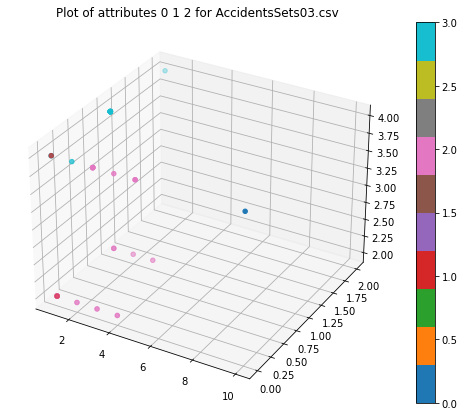

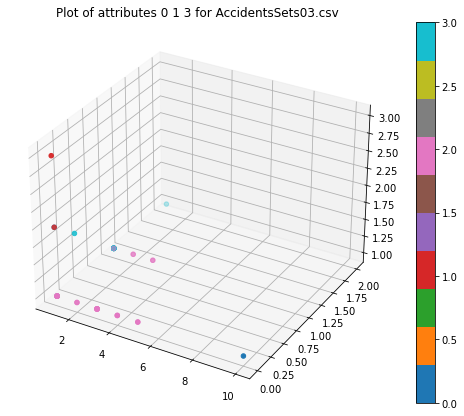

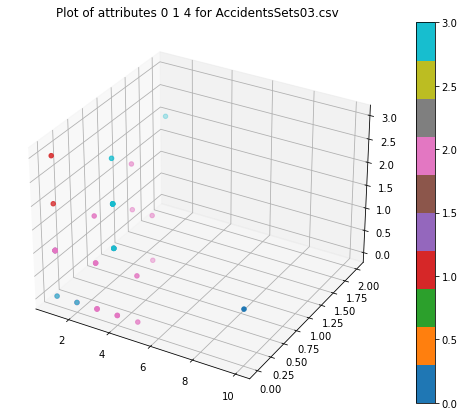

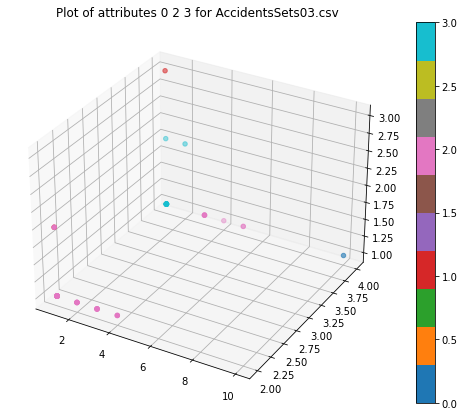

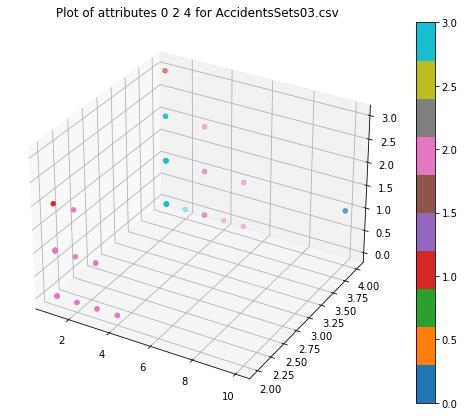

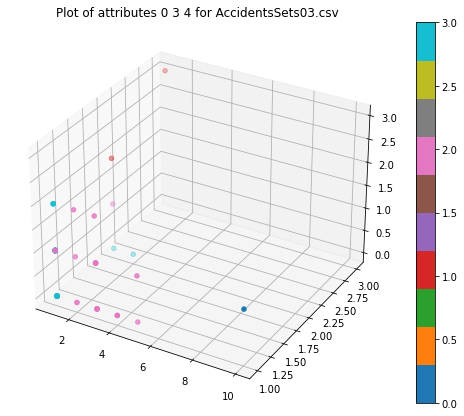

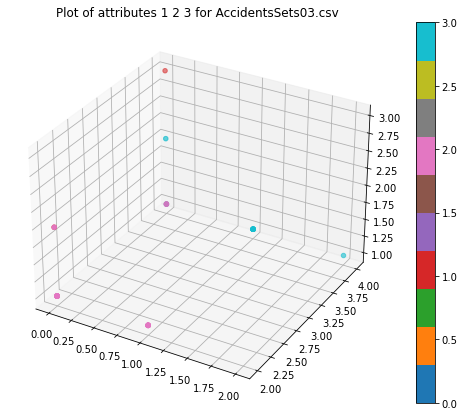

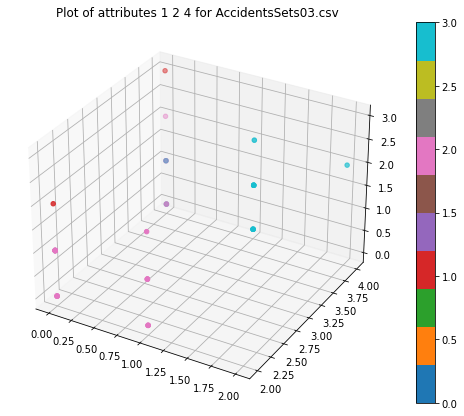

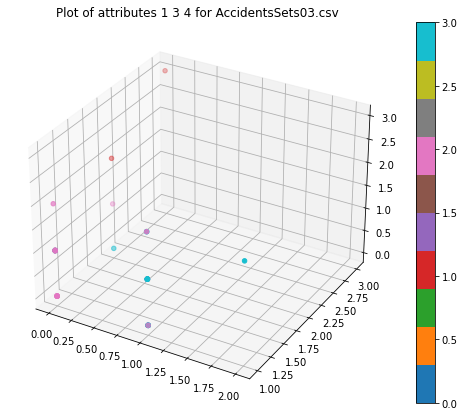

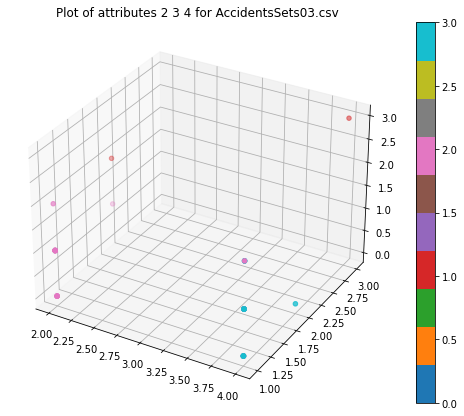

In [342]:
df_full, restr = readFiles('./data/AccidentsSet03.csv')
df,dropped = restrictdf(df_full, restr, getDropped=True)

centroids = initCentroids_max(df, 4, euclideanDist)
# centroids = initCentroids_random(df, 5)

df, centroids = kmeans_reassign(df, centroids, euclideanDist, 0)
# df, centroids = kmeans_sse(df, centroids, euclideanDist, 10)

clusters = analyzeClusters(df, centroids, euclideanDist, extraCols = dropped)

print()
for clusterInfo in clusters:
    for key in clusterInfo:
        if key == "dataPoints":
            print(f"{key}: \n{clusterInfo[key].iloc[:,-1].to_markdown()}")
        else:
            print(f"{key}: {clusterInfo[key]}")
    print('\n') 


for combo in combinations(df.columns[:-1], 3):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    cb = ax.scatter3D(df[combo[0]], df[combo[1]], df[combo[2]], c=df['cluster'], cmap='tab10')
    plt.colorbar(cb)
    plt.title(f"Plot of attributes {combo[0]} {combo[1]} {combo[2]} for AccidentsSets03.csv")
